<a href="https://colab.research.google.com/github/akashsukhija/Russian-Troll-Tweets-Detection/blob/main/Troll_tweet_detection_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import packages
import numpy as np
import pandas as pd
import os, re, csv, math, codecs
    
from sklearn import preprocessing 
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, roc_curve, auc

import keras
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Embedding, Activation, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.preprocessing import sequence

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 

import tqdm
import matplotlib.pyplot as plt

# Setting up GPU runtime

- To set the runtime to GPU, go to _Runtime->Change runtime type_ and set Hardware Accelerator to GPU.


## Mounting Google Drive and setting up data paths

In order to use Google Drive as storage to load and save data/models, we need to mount the drive. 

I am using the path /content/gdrive to point to my Google Drive storage but this can be changed. 

Once you mount the drive, the contents of it can be seen by clicking the __Files__ folder on left side of the window.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# download stopwords which will be removed from the text
nltk.download("stopwords")
tokenizer = RegexpTokenizer(r'\w+') # tokenizing on every word
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Section 1

### Storing the Word Embeddings
_As ours is a Text Mining Task, we are using low-dimensional word embeddings as an input to the deep learning model, these word embeddings are generated from a pre-trained model wiki.simple.vec which was generated from Wikipedia text using FastText Algorithm. The Code below tries to extract the word embeddings for each 'Word' from the pre-trained model and store it in the embeddings_index dictionary. The code then prints the number of word vectors found._

In [ ]:
print('loading word embeddings...')
embeddings_index = {}
f = codecs.open('drive/My Drive/IS577_Assignment5/wiki.simple.vec', encoding='utf-8')
for line in f:
    #print('Line is',line)
    values = line.rstrip().rsplit(' ')
    #print('value is',values)
    word = values[0]
    #print(word)
    coefs = np.asarray(values[1:], dtype='float32')
    #print(coefs)
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

loading word embeddings...
found 111052 word vectors


## Section 2

### Splitting the Data into Test-Train Splits

_Here we are assigning the train and test dataframes and then using the train-test-split function from sklearn to create the training and testing datasets from the above dataframes_

In [ ]:
train_df = pd.read_csv("drive/My Drive/IS577_Assignment5/train.csv", engine="python")
test_df = pd.read_csv("drive/My Drive/IS577_Assignment5/test.csv", engine="python")
x_train, x_test, y_train, y_test = train_df["content"], test_df["content"], train_df["troll"], test_df["troll"]
y_train_old = y_train
y_test_old = y_test

## Section 3

### Data Pre-Processing, Tokenization and Padding
In the below section, first, we are defining a function to pre-process the data. This function tokenizes the text corpus and filters out the stop words from the text corpus then storing it in a list. We are applying the pre-processing techniques to the training and testing datasets. Second, we tokenize the pre-processed datasets.Transforms the text in datasets to a sequence of integers. After creating the sequences, we transform the sequences (lists of integers) into a 2D Numpy array by padding the sequences with '0's to get sequences of same length.  _

In [ ]:
raw_docs_train = x_train
raw_docs_test = x_test
num_classes = 2
MAX_NB_WORDS = 100000
max_seq_len = 512

def preprocess(data):
  processed_data = []
  for doc in data:
      tokens = tokenizer.tokenize(doc)
      filtered = [word for word in tokens if word not in stop_words]
      processed_data.append(" ".join(filtered))
  return processed_data

print("pre-processing train data...")
processed_docs_train = preprocess(raw_docs_train)
print("pre-processing test data...")
processed_docs_test = preprocess(raw_docs_test)

print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

pre-processing train data...
pre-processing test data...
tokenizing input data...
dictionary size:  1007866


## Visualizing word embeddings

t-SNE (t-distributed stochastic neighbor embedding) is an algorithm that can be used to visualize high-dimensional data. Each word in our dataset is represented with a 300-dimensional vector, and t-SNE uses Principal Component Analysis (PCA) to visualize similar words by nearby points and dissimilar words by distant points.

https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

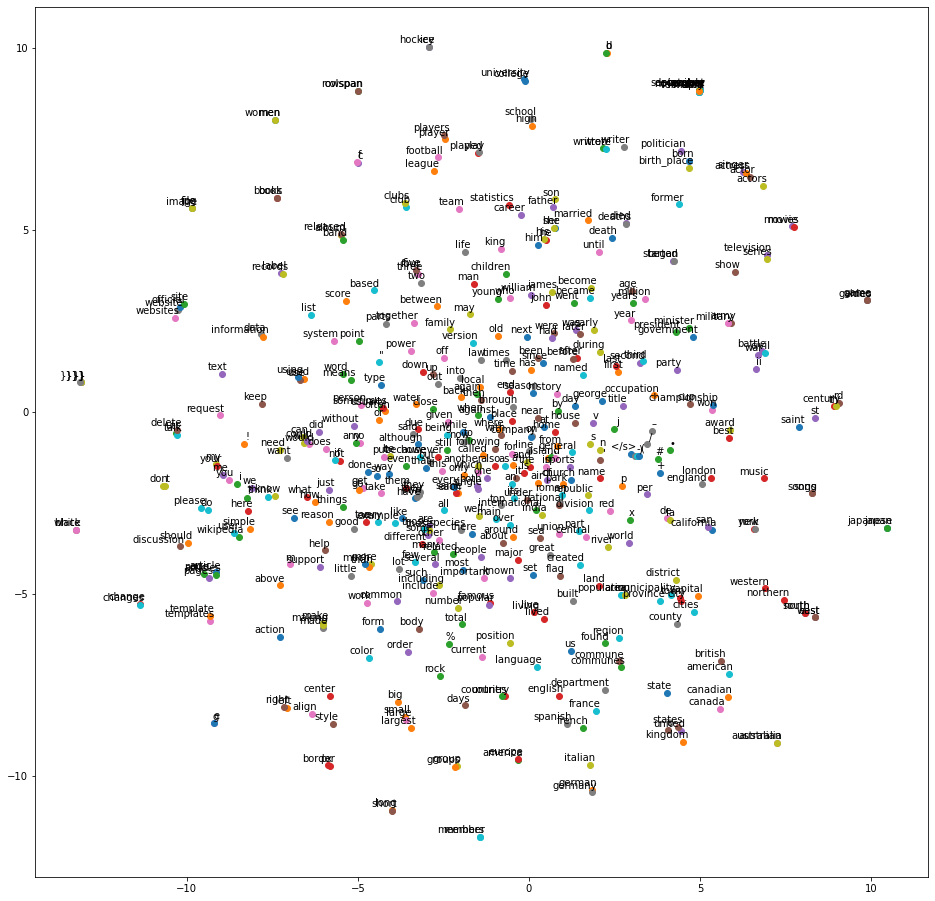

In [ ]:
# Visualizing only topK words in our dictionary
topK = 500
labels = list(embeddings_index.keys())[1:topK]
tokens = list(embeddings_index.values())[1:topK]
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(tokens)

x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])
    
plt.figure(figsize=(16, 16)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                  xy=(x[i], y[i]),
                  xytext=(5, 2),
                  textcoords='offset points',
                  ha='right',
                  va='bottom')
plt.show()

## Section 4
### Preparing the Embedding Matrix 
_Here we are creating the embedding matrix that will be fed to the Convolutional Neural Network  as Weights for the Embeddings Layer. Along with this we are also checking the Null Word Embeddings_

In [ ]:
print('preparing embedding matrix...')
embed_dim = 300 
words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index))
#print(len(word_index))
embedding_matrix = np.zeros((nb_words, embed_dim))
#print(embedding_matrix)
for word, i in word_index.items():
    if i >= nb_words:
        #print(i,nb_words)
        continue
    embedding_vector = embeddings_index.get(word)
    #print(embedding_vector)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)

print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
1007866
number of null word embeddings: 63831


## Section 5

### HyperParameter Tuning
_A word embedding is a class of approaches for representing words and documents using a dense vector representation. In an embedding, words are represented by dense vectors where a vector represents the projection of the word into a continuous vector space. We are using the Embedding Layer in Keras, our layer is initialized with weights from our embedding matrix. We have a total of 5 layers in our Neural Networks : Embedding Layer, 2 One-Dimensional Convolutional Layers, 2 Dense Layers. The optimizer we have used is the Adam Optimizer. We have fit the Label Encoder on the train and test response variables.  
*Reference Provided Below_

In [ ]:
#parameters

batch_size = 128 
num_epochs = 10
num_filters = 16
weight_decay = 1e-4
dropout_prob = 0.1
learning_rate = 0.001
validation_pct = 0.1

print("training CNN ...")
model = Sequential()
model.add(Embedding(nb_words, embed_dim,
          weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
model.add(Conv1D(num_filters, 7, activation='sigmoid', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 7, activation='sigmoid', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(dropout_prob))
model.add(Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(weight_decay)))
model.add(Dense(num_classes, activation='sigmoid'))  #multi-label (k-hot encoding)

adam = keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

training CNN ...
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 512, 300)          30000000  
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 512, 16)           33616     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 256, 16)           0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 256, 16)           1808      
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 16)                0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 3

In [ ]:
le = preprocessing.LabelEncoder()
# convert the target variable into a one-hot vector of size num_labels to be used in the model
try:
  y_train = le.fit_transform(y_train)
  y_train = to_categorical(y_train)

  y_test = le.fit_transform(y_test)
  y_test = to_categorical(y_test)

except:
  pass

## Section 6

### Fitting the Model on the Train Data
_In this section we are working towards fitting our trained model on the padded training data and test response vector data which is fit with the one-hot encoding_

In [ ]:
callbacks = [
    # This callback saves a SavedModel every 100 batches.
    # We include the training loss in the folder name.
    keras.callbacks.ModelCheckpoint(
        filepath="" + 'gdrive/My Drive/IS577_Assignment5/epoch={epoch}',
        save_best_only=True)
]
hist = model.fit(word_seq_train, y_train, batch_size=batch_size, epochs=num_epochs, callbacks=callbacks, validation_split=validation_pct, shuffle=True, verbose=2)


Epoch 1/10
INFO:tensorflow:Assets written to: gdrive/My Drive/IS577_Assignment5/epoch=1/assets
3379/3379 - 87s - loss: 0.3426 - accuracy: 0.8407 - val_loss: 0.2961 - val_accuracy: 0.8667
Epoch 2/10
INFO:tensorflow:Assets written to: gdrive/My Drive/IS577_Assignment5/epoch=2/assets
3379/3379 - 87s - loss: 0.2859 - accuracy: 0.8719 - val_loss: 0.2920 - val_accuracy: 0.8691
Epoch 3/10
INFO:tensorflow:Assets written to: gdrive/My Drive/IS577_Assignment5/epoch=3/assets
3379/3379 - 87s - loss: 0.2675 - accuracy: 0.8817 - val_loss: 0.2743 - val_accuracy: 0.8778
Epoch 4/10
INFO:tensorflow:Assets written to: gdrive/My Drive/IS577_Assignment5/epoch=4/assets
3379/3379 - 87s - loss: 0.2547 - accuracy: 0.8882 - val_loss: 0.2690 - val_accuracy: 0.8801
Epoch 5/10
INFO:tensorflow:Assets written to: gdrive/My Drive/IS577_Assignment5/epoch=5/assets
3379/3379 - 87s - loss: 0.2460 - accuracy: 0.8925 - val_loss: 0.2680 - val_accuracy: 0.8802
Epoch 6/10
3379/3379 - 86s - loss: 0.2387 - accuracy: 0.8960 - va

## Section 7

### Plotting the Results

_Plotting the results, Accuracy v Number of Epochs,Loss v Number of Epochs. We can see from the plots below that as the number of epochs increase, the validation accuracy and validation loss stay constant after a point._

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


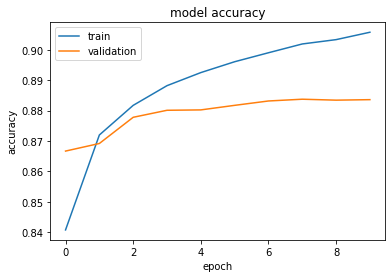

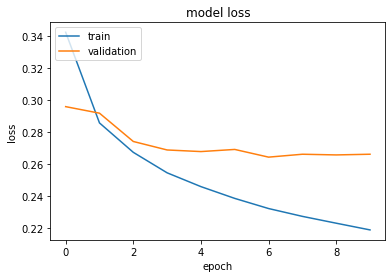

In [ ]:
print(hist.history.keys())
#  "Accuracy"
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Section 8 

### Classification Metrics and Area under the Curve
_In this section ,we are printing classification report of the model and checking the Area Under the Curve for a better understanding of the classification done by the model. Our Model has an AUC of 0.95 which is pretty decent for our text classifier_

              precision    recall  f1-score   support

           0       0.88      0.92      0.90     65614
           1       0.89      0.85      0.87     54519

    accuracy                           0.89    120133
   macro avg       0.89      0.88      0.88    120133
weighted avg       0.89      0.89      0.88    120133

AUC:  0.9578938748176802


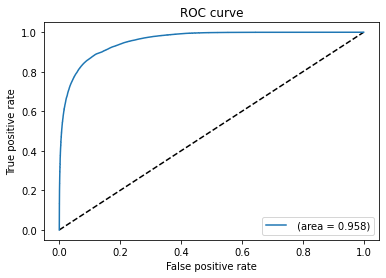

In [ ]:
prediction_probabilities = model.predict(word_seq_test)
predictions = np.argmax(prediction_probabilities, axis=1)
print(classification_report(y_test_old, predictions))
fpr, tpr, thresholds = roc_curve(y_test_old, prediction_probabilities[:, 1])
auc_k = auc(fpr, tpr)
print("AUC: ", auc_k)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label=' (area = {:.3f})'.format(auc_k))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()